In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
from scipy import signal
import os

class MemmapDataset(Dataset):
    def __init__(self, descriptor_path, padding_handling="remove", interp_length=None, transform=None, filter=False):
        """
        Args:
            descriptor_path (str): Path to the descriptor JSON file (e.g., 'descriptor.json').
            padding_handling (str or float): How to handle np.inf padding values.
                - "remove" (default): Remove the padded np.inf values and return variable-length arrays.
                - A float: Replace any np.inf values with the given float.
            interp_length (int, optional): If provided, the ADC data (adc1 and adc2) will be
                first stripped of np.inf padding and then interpolated to this fixed length.
            transform (callable, optional): Optional transform to be applied on a sample.
            filter (bool, optional): Whether to apply a bandpass filter to the audio data.
        """
        # Load descriptor from JSON file.
        with open(descriptor_path, 'r') as f:
            self.descriptor = json.load(f)
        
        # Extract required parameters from the descriptor.
        self.audio_sampling_rate = self.descriptor['audio_sampling_rate']
        self.adc_sampling_rate = self.descriptor['adc_sampling_rate']
        self.audio_lowcut       = self.descriptor['audio_lowcut']
        self.audio_highcut      = self.descriptor['audio_highcut']
        self.adc_lowcut         = self.descriptor['adc_lowcut']
        self.adc_highcut        = self.descriptor['adc_highcut']
        self.max_audio_len      = self.descriptor['max_audio_len']
        self.max_adc_len        = self.descriptor['max_adc_len']
        self.n_segments         = self.descriptor['n_segments']
        self.memmap_filename    = self.descriptor['memmap_filename']
        self.dataset_mapping    = self.descriptor['dataset_mapping']
        # Rebuild the dtype from the descriptor.
        self.dtype = np.dtype([tuple(item) for item in self.descriptor['dtype']])
        
        # Open the memmap file in read-only mode using the number of segments from the descriptor.
        self.memmap = np.memmap(self.memmap_filename, dtype=self.dtype, mode='r', shape=(self.n_segments,))
        
        self.transform = transform
        self.padding_handling = padding_handling
        self.interp_length = interp_length
        self.filter = filter

    def __len__(self):
        return self.n_segments

    def __getitem__(self, index):
        # Retrieve the record from the memmap.
        row = self.memmap[index]
        
        # Convert fixed-size arrays to numpy arrays.
        audio_arr = np.array(row['audio'])
        adc1_arr = np.array(row['adc1'])
        adc2_arr = np.array(row['adc2'])
        
        # Process audio channel using the padding handling method.
        audio_arr = self._handle_padding(audio_arr, self.padding_handling)
        adc1_arr = self._handle_padding(adc1_arr, self.padding_handling)
        adc2_arr = self._handle_padding(adc2_arr, self.padding_handling)
        
        if self.filter:
            audio_arr = self.BPfilter(audio_arr, self.audio_sampling_rate, self.audio_lowcut, self.audio_highcut)
            adc1_arr = self.BPfilter(adc1_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)
            adc2_arr = self.BPfilter(adc2_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)

        # Process ADC channels.
        if self.interp_length is not None:
            audio_arr = self._interpolate_channel(audio_arr, self.interp_length)
            adc1_arr = self._interpolate_channel(adc1_arr, self.interp_length)
            adc2_arr = self._interpolate_channel(adc2_arr, self.interp_length)
        
        # Create a sample tuple.
        # Use .copy() to ensure the arrays have positive strides.
        sample = ( 
            int(row['id']), 
            torch.from_numpy(audio_arr.copy()).float(),  
            torch.from_numpy(adc1_arr.copy()).float(), 
            torch.from_numpy(adc2_arr.copy()).float(),  
        )
        
        if self.transform:
            sample = self.transform(sample)
        return sample

    def _handle_padding(self, arr, mode):
        """
        Handle the np.inf padded values in the array.
        If mode is "remove", return the array with inf values removed.
        If mode is a float, replace inf values with that float.
        """
        if mode == "remove":
            return arr[~np.isinf(arr)]
        elif isinstance(mode, (int, float)):
            return np.where(np.isinf(arr), mode, arr)
        else:
            raise ValueError("Invalid padding_handling value. Use 'remove' or a float value.")

    def _interpolate_channel(self, arr, target_length):
        """
        Remove np.inf values from the array and linearly interpolate
        to the target_length.
        """
        # Remove padded inf values.
        valid = arr[~np.isinf(arr)]
        if len(valid) == 0:
            # If there is no valid data, return an array of zeros.
            return np.zeros(target_length, dtype=arr.dtype)
        # Generate new indices for interpolation.
        old_indices = np.arange(len(valid))
        new_indices = np.linspace(0, len(valid) - 1, target_length)
        return np.interp(new_indices, old_indices, valid)[:target_length]

    def get(self, field):
        """
        Return the value of the given descriptor field.
        For example, dataset.get("audio_sampling_rate") returns the audio sampling rate.
        """
        return self.descriptor.get(field, None)

    def id_to_dataset(self, id):
        """
        Return the dataset string for the given ID.
        """
        return self.dataset_mapping.get(str(id), "Unknown")

    def get_Nclasses(self):
        """
        Return the number of unique datasets in the dataset_mapping.
        """
        return len(set(self.dataset_mapping.values()))
    
    def BPfilter(self, data, fs, lowcut_hz=None, highcut_hz=None):
        """
        Apply a bandpass Butterworth filter to the input data.
        
        Parameters:
        data : array-like
            The input signal to filter
        fs : float
            Sampling frequency in Hz
        lowcut_hz : float, optional
            Lower cutoff frequency in Hz. If None, defaults to 20 Hz
        highcut_hz : float, optional
            Upper cutoff frequency in Hz. If None, defaults to fs/4 Hz
            
        Returns:
        array-like
            The filtered signal
        """
        # Default cutoff frequencies if not provided.
        if lowcut_hz is None:
            lowcut_hz = 20  # Default lower cutoff of 20 Hz
        if highcut_hz is None:
            highcut_hz = fs/4  # Default upper cutoff at quarter of sampling rate
        
        # Convert cutoff frequencies to normalized units (0 to 1).
        nyquist = fs / 2
        low = lowcut_hz / nyquist
        high = highcut_hz / nyquist
        
        # Create a 4th-order bandpass Butterworth filter.
        b, a = signal.butter(2, [low, high], btype='band')
        
        # Apply zero-phase filtering using filtfilt.
        filtered_data = signal.filtfilt(b, a, data)
        return filtered_data

class normalizer():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        id, audio, adc1, adc2 = sample
        audio = (audio - self.mean[0]) / self.std[0]
        adc1 = (adc1 - self.mean[1]) / self.std[1]
        adc2 = (adc2 - self.mean[1]) / self.std[1]
        return id, audio, adc1, adc2

input_length = 512
# Path to the descriptor JSON file.
descriptor_path = 'descriptor.json'
# Create a dataset instance that interpolates ADC channels to length 300, with filtering.
dataset = MemmapDataset(descriptor_path, padding_handling="remove", interp_length=input_length, filter=True)
transform = normalizer(mean=[dataset.get("audio_mean"), dataset.get("adc_mean")], std=[dataset.get("audio_std"), dataset.get("adc_std")])
dataset.transform = transform
output_length = dataset.get_Nclasses()
print("Number of classes:", output_length)
sample = dataset[1]
print(f"\nWith ADC interpolation to length {input_length} and filtering:")
print("ADC1 shape:", sample[2].shape)
print("ADC2 shape:", sample[3].shape)

# Demonstrate accessing a descriptor field.
print("Audio Sampling Rate:", dataset.get("audio_sampling_rate"))
print("ADC Highcut:", dataset.get("adc_highcut"))


Number of classes: 38

With ADC interpolation to length 300:
ADC1 shape: torch.Size([512])
ADC2 shape: torch.Size([512])
Audio Sampling Rate: 48000
ADC Highcut: 3700


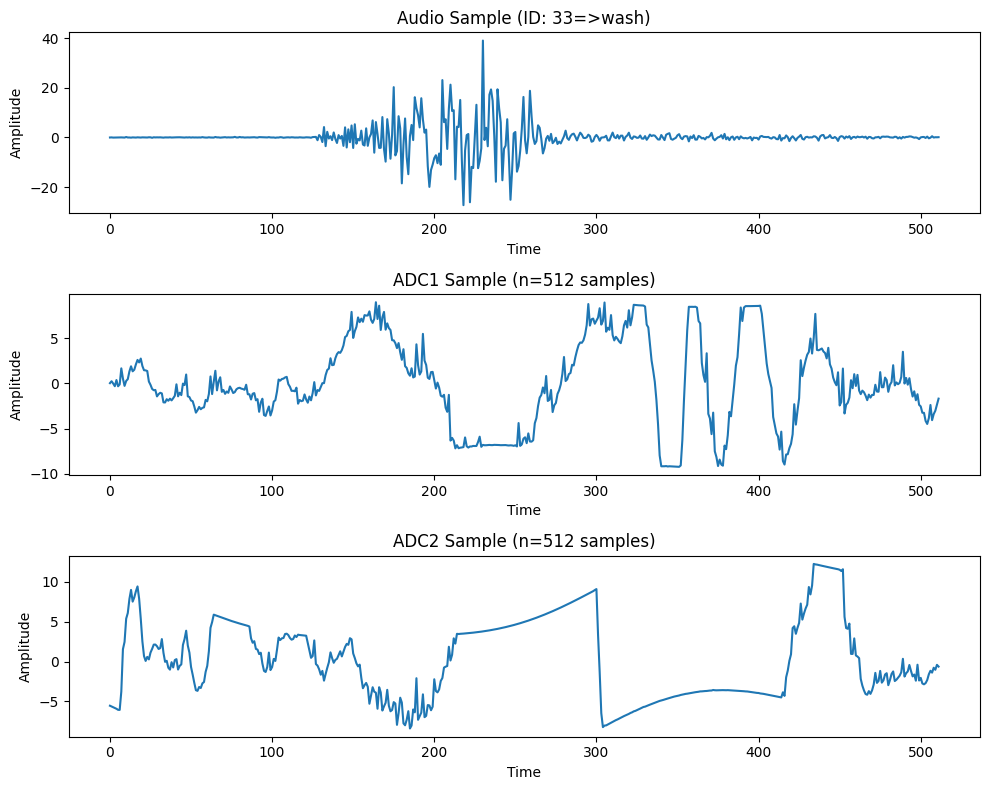

In [2]:
import matplotlib.pyplot as plt


rng_index = np.random.randint(0, len(dataset))
sample = dataset[rng_index]

sample_id, audio, adc1, adc2 = sample  # unpack the tuple

# Convert tensors to numpy arrays for plotting
audio_np = audio.numpy()
adc1_np = adc1.numpy()
adc2_np = adc2.numpy()

# Create a figure with three subplots for audio, ADC1, and ADC2.
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

axs[0].plot(audio_np)
axs[0].set_title(f"Audio Sample (ID: {sample_id}=>{dataset.id_to_dataset(sample_id)})")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")

axs[1].plot(adc1_np)
axs[1].set_title(f"ADC1 Sample (n={len(adc1_np)} samples)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Amplitude")

axs[2].plot(adc2_np)
axs[2].set_title(f"ADC2 Sample (n={len(adc2_np)} samples)")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [ ]:
# from torchprofile import profile_macs

import torch.nn as nn
import torch.nn.functional as F

# the data shape is (batch_size, 2, input_length)
# where 2 is the number of ADC channels and input_length is the length of each ADC channel.
# the output shape is (batch_size, output_length) where output_length is the number of classes.

# def computeModelStats(model, input_shape):
#     dummy_input = torch.randn(input_shape)
#     macs = profile_macs(model, dummy_input)
#     params = sum(p.numel() for p in model.parameters())
#     model_size = params * 4 / (1024 ** 2)  # Convert to MB assuming 32-bit (4 bytes) precision
#     print(f"MACs: {macs}")
#     print(f"Parameters: {params}")
#     print(f"Model Size: {model_size:.2f} MB")

def computeModelSize(model):
    params = sum(p.numel() for p in model.parameters())
    model_size = params * 4 / (1024 ** 2)  # Convert to MB assuming 32-bit (4 bytes) precision
    return model_size

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ELU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class AudioResNet(nn.Module):
    def __init__(self, input_length, input_dim,output_length):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ELU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 128, 4)
        self.layer2 = self._make_layer(128, 256, 2, stride=2)
        self.layer3 = self._make_layer(256, 512, 2, stride=2)
        self.layer4 = self._make_layer(512, 512, 4, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, output_length)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class ResNet(nn.Module):
    def __init__(self, input_length, input_dim,output_length):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ELU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 128, 2)
        self.layer2 = self._make_layer(128, 256, 2, stride=2)
        self.layer3 = self._make_layer(256, 512, 2, stride=2)
        self.layer4 = self._make_layer(512, 512, 4, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, output_length)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class SmallResNet(nn.Module):
    def __init__(self, input_length, input_dim, output_length):
        super(SmallResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ELU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(32, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 256, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, output_length)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Test the model with dummy data
dummy = torch.randn(4, 1, input_length)
model = ResNet(input_length, 1, output_length)
# Smodel = SmallResNet(input_length, 1, output_length)
output = model(dummy)
# Soutput = Smodel(dummy)
print("Output shape is:", output.shape)
print(model)
# print("Small Output shape is:", Soutput.shape)
# print(Smodel)

# Compute model stats
# computeModelStats(model, (1, 2, input_length))
print(f"Model Size: {computeModelSize(model):.2f} MB")
# print(f"Small Model Size: {computeModelSize(Smodel):.2f} MB")
# del Smodel

Output shape is: torch.Size([4, 38])
ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ELU(alpha=1.0, inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(alpha=1.0, inplace=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (

In [4]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_epoch(
    model,
    dataloader,
    epochs,
    optimizer=None,
    loss_function=None,
    scheduler=None,
    device='cpu',
    verbose=0,
    log_interval=100,
    logger=None,
):
    if loss_function is None:
        loss_function = nn.CrossEntropyLoss()
    
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    model.train()

    epoch_results = []

    for epoch in tqdm(range(epochs), desc="Training Epochs", disable=(verbose == 0)):
        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0
        
        for batch_idx, (ids, audio, adc1, adc2) in enumerate(dataloader):
            ids = ids.to(device)
            audio = audio.to(device)
            audio = audio.unsqueeze(1)
            audio += torch.randn_like(audio) * 0.02
            # adc1 = adc1.to(device)
            # adc2 = adc2.to(device)
            
            # adc = torch.stack((adc1, adc2), dim=1)
            outputs = model(audio)
            loss = loss_function(outputs, ids)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == ids).sum().item()
            total += ids.size(0)
            
            # if verbose > 0 and (batch_idx % log_interval == 0):
            #     msg = f"[TRAIN] Epoch: {epoch}/{epochs}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%"
            #     if verbose == 1:
            #         print(msg)
            #     if logger is not None and verbose != 0:
            #         logger.log({"split": "train", "epoch": epoch, "batch_idx": batch_idx, "loss": loss.item(), "accuracy": 100 * correct / total})

        if scheduler is not None:
            scheduler.step()

        avg_loss = total_loss / max(num_batches, 1)
        accuracy = 100 * correct / total
        epoch_results.append((avg_loss, accuracy))
        if verbose == 1:
            print(f"[TRAIN] End of Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        if logger is not None and verbose != 0:
            logger.log({"split": "train", "epoch": epoch, "avg_loss": avg_loss, "accuracy": accuracy})


    return epoch_results


def test_epoch(
    model,
    dataloader,
    epochs=1,
    loss_function=None,
    device='cpu',
    verbose=0,
    log_interval=100,
    logger=None,
):
    if loss_function is None:
        loss_function = nn.CrossEntropyLoss()

    model.to(device)
    model.eval()

    epoch_results = []

    for epoch in tqdm(range(epochs), desc="Testing Epochs", disable=(verbose == 0)):
        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0

        with torch.no_grad():
            for batch_idx, (ids, audio, adc1, adc2) in enumerate(dataloader):
                ids = ids.to(device)
                audio = audio.to(device)
                audio = audio.unsqueeze(1)
                # adc1 = adc1.to(device)
                # adc2 = adc2.to(device)
                
                # adc = torch.stack((adc1, adc2), dim=1)
                outputs = model(audio)
                loss = loss_function(outputs, ids)
                
                total_loss += loss.item()
                num_batches += 1
                
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == ids).sum().item()
                total += ids.size(0)
                
                # if verbose > 0 and (batch_idx % log_interval == 0):
                #     msg = f"[TEST] Epoch: {epoch}/{epochs}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%"
                #     if verbose == 1:
                #         print(msg)
                #     if logger is not None and verbose != 0:
                #         logger.log({"split": "test", "epoch": epoch, "batch_idx": batch_idx, "loss": loss.item(), "accuracy": 100 * correct / total})

        avg_loss = total_loss / max(num_batches, 1)
        accuracy = 100 * correct / total
        epoch_results.append((avg_loss, accuracy))
        if verbose == 1:
            print(f"[TEST] End of Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        if logger is not None and verbose != 0:
            logger.log({"split": "test", "epoch": epoch, "avg_loss": avg_loss, "accuracy": accuracy})


    return epoch_results


In [5]:
from torch.utils.data import DataLoader, random_split

# Define the dataset split ratio
train_ratio = 0.8
val_ratio = 0.2

# Calculate the number of samples for training and validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)

# Sample 100 elements from both training and validation datasets for testing
for i, (ids, audio, adc1, adc2) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    audio = torch.unsqueeze(audio, 1)
    print("Audio shape:", audio.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break

for i, (ids, audio, adc1, adc2) in enumerate(val_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("Audio shape:", audio.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break
    


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Batch 1:
IDs: tensor([23, 35, 28, 31,  2, 28, 25, 27, 19, 14, 24,  9, 25,  7, 17, 12, 18, 22,
        37, 21, 30, 35, 13, 28, 32, 11, 15,  4, 36, 21, 26, 18])
Audio shape: torch.Size([32, 1, 512])
ADC1 shape: torch.Size([32, 512])
ADC2 shape: torch.Size([32, 512])
Batch 2:
IDs: tensor([ 7, 11, 14, 31, 10, 15, 31, 33,  0, 24, 32, 29,  3, 10, 18, 36, 20, 15,
        36, 29, 10,  4, 22,  2, 20, 28,  9,  7, 15, 30, 33, 23])
Audio shape: torch.Size([32, 1, 512])
ADC1 shape: torch.Size([32, 512])
ADC2 shape: torch.Size([32, 512])
Batch 1:
IDs: tensor([22, 10,  6, 31, 14, 27, 31, 21, 17, 19, 17, 34, 32, 30, 22, 18, 11, 10,
         9, 25, 18, 36, 24, 36, 28, 22,  3, 16, 28, 19,  3, 25])
Audio shape: torch.Size([32, 512])
ADC1 shape: torch.Size([32, 512])
ADC2 shape: torch.Size([32, 512])
Batch 2:
IDs: tensor([24,  6,  8, 21,  4, 18, 20, 15, 37, 20, 14,  3,  0, 33,  7, 33, 18, 28,
        16, 32, 33, 22,  0,  4, 18, 30, 35,  1,  8,  3, 28,  9])
Audio shape: torch.Size([32, 512])
ADC1 shape: to

In [6]:
# !wandb login

In [7]:
# import wandb

# # Initialize W&B
# wandb.init(project="Murmurations")

# # Configure W&B logging
# config = wandb.config
# config.learning_rate = 0.001
# config.epochs = 10
# config.batch_size = 4


In [8]:
TOTAL_EPOCHS = 240
PER_EPOCH = 2

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, TOTAL_EPOCHS, eta_min=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=3, eta_min=0.0001)
if torch.backends.mps.is_available():
    global_device = torch.device("mps")
else:
    global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
verbosity = 1

In [9]:
# the actual trainign loop
train_stats = []
test_stats = []
best_test_acc = 0
for epoch in tqdm(range(TOTAL_EPOCHS), desc="TOTAL Epochs", disable=(verbosity == 0)):
    res =train_epoch(model, train_loader, epochs=PER_EPOCH, device=global_device, verbose=1, optimizer=optimizer, loss_function=criterion, scheduler=scheduler)
    train_stats.extend(res)
    res = test_epoch(model, val_loader, epochs=1, device=global_device, verbose=1, loss_function=criterion)
    if res[-1][1] > best_test_acc:
        best_test_acc = res[-1][1]
        torch.save(model.state_dict(), "best_audiomodel.pth")
        print(f"Best model saved with accuracy: {best_test_acc:.2f}%")
    test_stats.extend(res)



TOTAL Epochs:   0%|          | 0/240 [00:00<?, ?it/s]

[TRAIN] End of Epoch 0, Avg Loss: 2.8815, Accuracy: 33.82%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.2175, Accuracy: 64.01%


TOTAL Epochs:   0%|          | 1/240 [00:02<11:51,  2.98s/it]

[TEST] End of Epoch 0, Avg Loss: 4.1569, Accuracy: 31.03%
Best model saved with accuracy: 31.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.9258, Accuracy: 78.35%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.7972, Accuracy: 82.92%


TOTAL Epochs:   1%|          | 2/240 [00:05<10:32,  2.66s/it]

[TEST] End of Epoch 0, Avg Loss: 2.1555, Accuracy: 68.30%
Best model saved with accuracy: 68.30%


[TRAIN] End of Epoch 0, Avg Loss: 1.6680, Accuracy: 87.95%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5822, Accuracy: 92.13%


TOTAL Epochs:   1%|▏         | 3/240 [00:07<10:03,  2.55s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6824, Accuracy: 86.83%
Best model saved with accuracy: 86.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.5330, Accuracy: 93.81%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4769, Accuracy: 95.98%


TOTAL Epochs:   2%|▏         | 4/240 [00:10<09:51,  2.51s/it]

[TEST] End of Epoch 0, Avg Loss: 1.8626, Accuracy: 79.02%


[TRAIN] End of Epoch 0, Avg Loss: 1.4317, Accuracy: 97.32%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3933, Accuracy: 98.72%


TOTAL Epochs:   2%|▏         | 5/240 [00:12<09:44,  2.49s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4840, Accuracy: 92.63%
Best model saved with accuracy: 92.63%


[TRAIN] End of Epoch 0, Avg Loss: 1.6691, Accuracy: 87.56%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.6457, Accuracy: 88.56%


TOTAL Epochs:   2%|▎         | 6/240 [00:15<09:37,  2.47s/it]

[TEST] End of Epoch 0, Avg Loss: 2.0954, Accuracy: 72.10%


[TRAIN] End of Epoch 0, Avg Loss: 1.5630, Accuracy: 91.41%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4864, Accuracy: 94.70%


TOTAL Epochs:   3%|▎         | 7/240 [00:17<09:27,  2.43s/it]

[TEST] End of Epoch 0, Avg Loss: 2.0916, Accuracy: 69.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.4304, Accuracy: 96.71%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3993, Accuracy: 97.71%


TOTAL Epochs:   3%|▎         | 8/240 [00:19<09:19,  2.41s/it]

[TEST] End of Epoch 0, Avg Loss: 1.5549, Accuracy: 92.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.3676, Accuracy: 98.72%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3705, Accuracy: 98.55%


TOTAL Epochs:   4%|▍         | 9/240 [00:22<09:12,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.5055, Accuracy: 92.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.3325, Accuracy: 99.55%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3160, Accuracy: 99.78%


TOTAL Epochs:   4%|▍         | 10/240 [00:24<09:12,  2.40s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4846, Accuracy: 92.86%
Best model saved with accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2965, Accuracy: 99.89%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2976, Accuracy: 99.83%


TOTAL Epochs:   5%|▍         | 11/240 [00:27<09:13,  2.42s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4298, Accuracy: 94.87%
Best model saved with accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2923, Accuracy: 99.89%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2760, Accuracy: 100.00%


TOTAL Epochs:   5%|▌         | 12/240 [00:28<08:19,  2.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4245, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2756, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2610, Accuracy: 100.00%


TOTAL Epochs:   5%|▌         | 13/240 [00:31<08:34,  2.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3903, Accuracy: 95.31%
Best model saved with accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2525, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2525, Accuracy: 99.94%


TOTAL Epochs:   6%|▌         | 14/240 [00:33<08:42,  2.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3567, Accuracy: 95.98%
Best model saved with accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2476, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2410, Accuracy: 100.00%


TOTAL Epochs:   6%|▋         | 15/240 [00:36<08:50,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3948, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2367, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2315, Accuracy: 100.00%


TOTAL Epochs:   7%|▋         | 16/240 [00:38<08:48,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3787, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2325, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2283, Accuracy: 100.00%


TOTAL Epochs:   7%|▋         | 17/240 [00:40<08:49,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3569, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2266, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2249, Accuracy: 100.00%


TOTAL Epochs:   8%|▊         | 18/240 [00:43<08:46,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3535, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2227, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2209, Accuracy: 100.00%


TOTAL Epochs:   8%|▊         | 19/240 [00:45<08:40,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3569, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2201, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2198, Accuracy: 100.00%


TOTAL Epochs:   8%|▊         | 20/240 [00:47<08:36,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3545, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.3934, Accuracy: 95.81%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5458, Accuracy: 92.02%


TOTAL Epochs:   9%|▉         | 21/240 [00:50<08:32,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 2.7043, Accuracy: 54.91%


[TRAIN] End of Epoch 0, Avg Loss: 1.4137, Accuracy: 97.66%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3352, Accuracy: 99.22%


TOTAL Epochs:   9%|▉         | 22/240 [00:52<08:30,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4188, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2930, Accuracy: 99.67%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2832, Accuracy: 99.89%


TOTAL Epochs:  10%|▉         | 23/240 [00:54<08:25,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4737, Accuracy: 91.96%


[TRAIN] End of Epoch 0, Avg Loss: 1.2730, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2664, Accuracy: 99.83%


TOTAL Epochs:  10%|█         | 24/240 [00:57<08:25,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3637, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2572, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2579, Accuracy: 99.78%


TOTAL Epochs:  10%|█         | 25/240 [00:58<07:40,  2.14s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4213, Accuracy: 93.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.2484, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2607, Accuracy: 99.83%


TOTAL Epochs:  11%|█         | 26/240 [01:01<07:50,  2.20s/it]

[TEST] End of Epoch 0, Avg Loss: 2.3237, Accuracy: 63.39%


[TRAIN] End of Epoch 0, Avg Loss: 1.2810, Accuracy: 99.67%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2503, Accuracy: 99.94%


TOTAL Epochs:  11%|█▏        | 27/240 [01:03<07:58,  2.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4474, Accuracy: 94.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.2405, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2364, Accuracy: 100.00%


TOTAL Epochs:  12%|█▏        | 28/240 [01:05<07:59,  2.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3832, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2389, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2405, Accuracy: 100.00%


TOTAL Epochs:  12%|█▏        | 29/240 [01:08<08:07,  2.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4848, Accuracy: 93.30%


[TRAIN] End of Epoch 0, Avg Loss: 1.2366, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2357, Accuracy: 100.00%


TOTAL Epochs:  12%|█▎        | 30/240 [01:10<08:15,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3967, Accuracy: 93.53%


[TRAIN] End of Epoch 0, Avg Loss: 1.2380, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2334, Accuracy: 100.00%


TOTAL Epochs:  13%|█▎        | 31/240 [01:13<08:24,  2.41s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3825, Accuracy: 96.21%
Best model saved with accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2322, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2371, Accuracy: 100.00%


TOTAL Epochs:  13%|█▎        | 32/240 [01:15<08:19,  2.40s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4180, Accuracy: 94.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.2377, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2287, Accuracy: 100.00%


TOTAL Epochs:  14%|█▍        | 33/240 [01:18<08:16,  2.40s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4051, Accuracy: 94.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.2292, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2347, Accuracy: 100.00%


TOTAL Epochs:  14%|█▍        | 34/240 [01:20<08:12,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4098, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2371, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2348, Accuracy: 100.00%


TOTAL Epochs:  15%|█▍        | 35/240 [01:22<08:08,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4048, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2256, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2216, Accuracy: 100.00%


TOTAL Epochs:  15%|█▌        | 36/240 [01:25<08:07,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3912, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2223, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2202, Accuracy: 100.00%


TOTAL Epochs:  15%|█▌        | 37/240 [01:27<08:04,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3917, Accuracy: 94.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2216, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2190, Accuracy: 100.00%


TOTAL Epochs:  16%|█▌        | 38/240 [01:29<08:00,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3989, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2226, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2163, Accuracy: 100.00%


TOTAL Epochs:  16%|█▋        | 39/240 [01:31<07:05,  2.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3487, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2158, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2177, Accuracy: 100.00%


TOTAL Epochs:  17%|█▋        | 40/240 [01:33<07:18,  2.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3624, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2159, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2120, Accuracy: 100.00%


TOTAL Epochs:  17%|█▋        | 41/240 [01:36<07:28,  2.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3513, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2112, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2138, Accuracy: 100.00%


TOTAL Epochs:  18%|█▊        | 42/240 [01:38<07:31,  2.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3887, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2117, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2122, Accuracy: 100.00%


TOTAL Epochs:  18%|█▊        | 43/240 [01:41<07:39,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3989, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2128, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2121, Accuracy: 100.00%


TOTAL Epochs:  18%|█▊        | 44/240 [01:43<07:37,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3705, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2132, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2150, Accuracy: 100.00%


TOTAL Epochs:  19%|█▉        | 45/240 [01:45<07:37,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3958, Accuracy: 94.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2130, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2111, Accuracy: 100.00%


TOTAL Epochs:  19%|█▉        | 46/240 [01:48<07:35,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3649, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2123, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2120, Accuracy: 100.00%


TOTAL Epochs:  20%|█▉        | 47/240 [01:50<07:37,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3605, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2087, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2080, Accuracy: 100.00%


TOTAL Epochs:  20%|██        | 48/240 [01:52<07:34,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3664, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2088, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2074, Accuracy: 100.00%


TOTAL Epochs:  20%|██        | 49/240 [01:55<07:32,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3577, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2073, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2060, Accuracy: 100.00%


TOTAL Epochs:  21%|██        | 50/240 [01:57<07:28,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3632, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2068, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2070, Accuracy: 100.00%


TOTAL Epochs:  21%|██▏       | 51/240 [01:59<07:27,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3719, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2067, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2051, Accuracy: 100.00%


TOTAL Epochs:  22%|██▏       | 52/240 [02:02<07:26,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3539, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2045, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2037, Accuracy: 100.00%


TOTAL Epochs:  22%|██▏       | 53/240 [02:04<06:42,  2.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3529, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2044, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2047, Accuracy: 100.00%


TOTAL Epochs:  22%|██▎       | 54/240 [02:06<06:49,  2.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3554, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2044, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2052, Accuracy: 100.00%


TOTAL Epochs:  23%|██▎       | 55/240 [02:08<06:56,  2.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3542, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2040, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2032, Accuracy: 100.00%


TOTAL Epochs:  23%|██▎       | 56/240 [02:11<07:01,  2.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3497, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2026, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2020, Accuracy: 100.00%


TOTAL Epochs:  24%|██▍       | 57/240 [02:13<07:06,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3484, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2026, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2021, Accuracy: 100.00%


TOTAL Epochs:  24%|██▍       | 58/240 [02:15<07:10,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3517, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2019, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2019, Accuracy: 100.00%


TOTAL Epochs:  25%|██▍       | 59/240 [02:18<07:10,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3512, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2018, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2018, Accuracy: 100.00%


TOTAL Epochs:  25%|██▌       | 60/240 [02:20<07:07,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3543, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2019, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2018, Accuracy: 100.00%


TOTAL Epochs:  25%|██▌       | 61/240 [02:23<07:04,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3460, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2013, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2016, Accuracy: 100.00%


TOTAL Epochs:  26%|██▌       | 62/240 [02:25<07:04,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3516, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2010, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2012, Accuracy: 100.00%


TOTAL Epochs:  26%|██▋       | 63/240 [02:27<07:03,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3470, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2007, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2009, Accuracy: 100.00%


TOTAL Epochs:  27%|██▋       | 64/240 [02:30<07:02,  2.40s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3562, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2008, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2005, Accuracy: 100.00%


TOTAL Epochs:  27%|██▋       | 65/240 [02:32<06:56,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3570, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 2.0128, Accuracy: 71.26%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.6417, Accuracy: 87.33%


TOTAL Epochs:  28%|██▊       | 66/240 [02:34<06:14,  2.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.9586, Accuracy: 76.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.4581, Accuracy: 95.70%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4100, Accuracy: 97.21%


TOTAL Epochs:  28%|██▊       | 67/240 [02:36<06:24,  2.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4768, Accuracy: 92.19%


[TRAIN] End of Epoch 0, Avg Loss: 1.3730, Accuracy: 97.88%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3237, Accuracy: 99.33%


TOTAL Epochs:  28%|██▊       | 68/240 [02:39<06:31,  2.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4812, Accuracy: 91.96%


[TRAIN] End of Epoch 0, Avg Loss: 1.3034, Accuracy: 99.61%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3033, Accuracy: 99.44%


TOTAL Epochs:  29%|██▉       | 69/240 [02:41<06:35,  2.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4071, Accuracy: 93.97%


[TRAIN] End of Epoch 0, Avg Loss: 1.3012, Accuracy: 99.44%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2752, Accuracy: 99.89%


TOTAL Epochs:  29%|██▉       | 70/240 [02:43<06:34,  2.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3714, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2652, Accuracy: 99.89%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2542, Accuracy: 99.94%


TOTAL Epochs:  30%|██▉       | 71/240 [02:46<06:32,  2.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4500, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2571, Accuracy: 99.89%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2474, Accuracy: 99.94%


TOTAL Epochs:  30%|███       | 72/240 [02:48<06:31,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6578, Accuracy: 86.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.2477, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2454, Accuracy: 100.00%


TOTAL Epochs:  30%|███       | 73/240 [02:50<06:32,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4585, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2585, Accuracy: 99.89%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2493, Accuracy: 100.00%


TOTAL Epochs:  31%|███       | 74/240 [02:53<06:27,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4633, Accuracy: 91.07%


[TRAIN] End of Epoch 0, Avg Loss: 1.2422, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2366, Accuracy: 100.00%


TOTAL Epochs:  31%|███▏      | 75/240 [02:55<06:28,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3769, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2443, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2392, Accuracy: 100.00%


TOTAL Epochs:  32%|███▏      | 76/240 [02:57<06:28,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4862, Accuracy: 91.96%


[TRAIN] End of Epoch 0, Avg Loss: 1.2288, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2312, Accuracy: 100.00%


TOTAL Epochs:  32%|███▏      | 77/240 [03:00<06:30,  2.40s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3423, Accuracy: 96.65%
Best model saved with accuracy: 96.65%


[TRAIN] End of Epoch 0, Avg Loss: 1.2290, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2278, Accuracy: 100.00%


TOTAL Epochs:  32%|███▎      | 78/240 [03:02<06:28,  2.40s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3942, Accuracy: 94.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2278, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2272, Accuracy: 100.00%


TOTAL Epochs:  33%|███▎      | 79/240 [03:05<06:29,  2.42s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4130, Accuracy: 94.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2302, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2290, Accuracy: 100.00%


TOTAL Epochs:  33%|███▎      | 80/240 [03:06<05:50,  2.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4386, Accuracy: 91.96%


[TRAIN] End of Epoch 0, Avg Loss: 1.2315, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2403, Accuracy: 100.00%


TOTAL Epochs:  34%|███▍      | 81/240 [03:09<05:58,  2.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6189, Accuracy: 85.27%


[TRAIN] End of Epoch 0, Avg Loss: 1.2441, Accuracy: 99.78%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2477, Accuracy: 99.94%


TOTAL Epochs:  34%|███▍      | 82/240 [03:11<06:01,  2.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3919, Accuracy: 93.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.2305, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2265, Accuracy: 100.00%


TOTAL Epochs:  35%|███▍      | 83/240 [03:14<06:04,  2.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4037, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2224, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2248, Accuracy: 100.00%


TOTAL Epochs:  35%|███▌      | 84/240 [03:16<06:04,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3691, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2277, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2305, Accuracy: 99.89%


TOTAL Epochs:  35%|███▌      | 85/240 [03:18<06:01,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3951, Accuracy: 94.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.2337, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2476, Accuracy: 99.94%


TOTAL Epochs:  36%|███▌      | 86/240 [03:21<06:02,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4133, Accuracy: 94.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2343, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2327, Accuracy: 100.00%


TOTAL Epochs:  36%|███▋      | 87/240 [03:23<06:03,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3740, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2233, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2203, Accuracy: 100.00%


TOTAL Epochs:  37%|███▋      | 88/240 [03:25<05:58,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3803, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2273, Accuracy: 99.89%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2197, Accuracy: 100.00%


TOTAL Epochs:  37%|███▋      | 89/240 [03:28<05:57,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3371, Accuracy: 96.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.2189, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2211, Accuracy: 100.00%


TOTAL Epochs:  38%|███▊      | 90/240 [03:30<05:55,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4186, Accuracy: 93.97%


[TRAIN] End of Epoch 0, Avg Loss: 1.2269, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2187, Accuracy: 100.00%


TOTAL Epochs:  38%|███▊      | 91/240 [03:33<05:54,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3546, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2175, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2201, Accuracy: 100.00%


TOTAL Epochs:  38%|███▊      | 92/240 [03:35<05:52,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4317, Accuracy: 92.19%


[TRAIN] End of Epoch 0, Avg Loss: 1.2213, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2199, Accuracy: 100.00%


TOTAL Epochs:  39%|███▉      | 93/240 [03:37<05:20,  2.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4176, Accuracy: 93.30%


[TRAIN] End of Epoch 0, Avg Loss: 1.2187, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2187, Accuracy: 100.00%


TOTAL Epochs:  39%|███▉      | 94/240 [03:39<05:29,  2.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4402, Accuracy: 92.19%


[TRAIN] End of Epoch 0, Avg Loss: 1.2240, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2532, Accuracy: 99.22%


TOTAL Epochs:  40%|███▉      | 95/240 [03:42<05:31,  2.29s/it]

[TEST] End of Epoch 0, Avg Loss: 2.0084, Accuracy: 71.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.3443, Accuracy: 97.60%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2650, Accuracy: 99.94%


TOTAL Epochs:  40%|████      | 96/240 [03:44<05:33,  2.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4024, Accuracy: 93.08%


[TRAIN] End of Epoch 0, Avg Loss: 1.2298, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2198, Accuracy: 100.00%


TOTAL Epochs:  40%|████      | 97/240 [03:46<05:34,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3804, Accuracy: 94.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.2175, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2152, Accuracy: 100.00%


TOTAL Epochs:  41%|████      | 98/240 [03:49<05:32,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3679, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2131, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2116, Accuracy: 100.00%


TOTAL Epochs:  41%|████▏     | 99/240 [03:51<05:29,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3512, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2117, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2089, Accuracy: 100.00%


TOTAL Epochs:  42%|████▏     | 100/240 [03:53<05:29,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3610, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2082, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2087, Accuracy: 100.00%


TOTAL Epochs:  42%|████▏     | 101/240 [03:56<05:30,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3543, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2094, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2114, Accuracy: 100.00%


TOTAL Epochs:  42%|████▎     | 102/240 [03:58<05:28,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3686, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2120, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2121, Accuracy: 100.00%


TOTAL Epochs:  43%|████▎     | 103/240 [04:00<05:22,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3695, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2126, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2134, Accuracy: 99.94%


TOTAL Epochs:  43%|████▎     | 104/240 [04:03<05:20,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3643, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2302, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2232, Accuracy: 99.94%


TOTAL Epochs:  44%|████▍     | 105/240 [04:05<05:17,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4846, Accuracy: 90.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2259, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2192, Accuracy: 100.00%


TOTAL Epochs:  44%|████▍     | 106/240 [04:08<05:18,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3936, Accuracy: 93.53%


[TRAIN] End of Epoch 0, Avg Loss: 1.2186, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2168, Accuracy: 100.00%


TOTAL Epochs:  45%|████▍     | 107/240 [04:09<04:46,  2.16s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3683, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2114, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2154, Accuracy: 99.94%


TOTAL Epochs:  45%|████▌     | 108/240 [04:12<04:52,  2.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4143, Accuracy: 92.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.2467, Accuracy: 99.61%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2676, Accuracy: 99.27%


TOTAL Epochs:  45%|████▌     | 109/240 [04:14<04:56,  2.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4156, Accuracy: 93.30%


[TRAIN] End of Epoch 0, Avg Loss: 1.2318, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2170, Accuracy: 100.00%


TOTAL Epochs:  46%|████▌     | 110/240 [04:16<04:55,  2.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3722, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2118, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2084, Accuracy: 100.00%


TOTAL Epochs:  46%|████▋     | 111/240 [04:19<04:57,  2.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3392, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2062, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2063, Accuracy: 100.00%


TOTAL Epochs:  47%|████▋     | 112/240 [04:21<04:59,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3580, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2057, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2055, Accuracy: 100.00%


TOTAL Epochs:  47%|████▋     | 113/240 [04:23<04:58,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3284, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2062, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2061, Accuracy: 100.00%


TOTAL Epochs:  48%|████▊     | 114/240 [04:26<04:54,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3521, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2064, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2060, Accuracy: 100.00%


TOTAL Epochs:  48%|████▊     | 115/240 [04:28<04:53,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3607, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2059, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2055, Accuracy: 100.00%


TOTAL Epochs:  48%|████▊     | 116/240 [04:31<04:54,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3467, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2053, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2066, Accuracy: 100.00%


TOTAL Epochs:  49%|████▉     | 117/240 [04:33<04:52,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3640, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2064, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2057, Accuracy: 100.00%


TOTAL Epochs:  49%|████▉     | 118/240 [04:35<04:48,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3482, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2068, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2090, Accuracy: 100.00%


TOTAL Epochs:  50%|████▉     | 119/240 [04:38<04:45,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3797, Accuracy: 94.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2123, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2121, Accuracy: 100.00%


TOTAL Epochs:  50%|█████     | 120/240 [04:39<04:19,  2.16s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3662, Accuracy: 93.97%


[TRAIN] End of Epoch 0, Avg Loss: 1.2168, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2403, Accuracy: 99.72%


TOTAL Epochs:  50%|█████     | 121/240 [04:42<04:27,  2.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4343, Accuracy: 92.19%


[TRAIN] End of Epoch 0, Avg Loss: 1.2598, Accuracy: 99.72%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2284, Accuracy: 100.00%


TOTAL Epochs:  51%|█████     | 122/240 [04:44<04:30,  2.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3649, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2108, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2078, Accuracy: 100.00%


TOTAL Epochs:  51%|█████▏    | 123/240 [04:47<04:33,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3337, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2056, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2038, Accuracy: 100.00%


TOTAL Epochs:  52%|█████▏    | 124/240 [04:49<04:32,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3330, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2060, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2043, Accuracy: 100.00%


TOTAL Epochs:  52%|█████▏    | 125/240 [04:51<04:28,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3403, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2044, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2036, Accuracy: 100.00%


TOTAL Epochs:  52%|█████▎    | 126/240 [04:54<04:28,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3305, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2032, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2034, Accuracy: 100.00%


TOTAL Epochs:  53%|█████▎    | 127/240 [04:56<04:27,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3315, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2039, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2036, Accuracy: 100.00%


TOTAL Epochs:  53%|█████▎    | 128/240 [04:58<04:25,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3457, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2040, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2039, Accuracy: 100.00%


TOTAL Epochs:  54%|█████▍    | 129/240 [05:01<04:21,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3394, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2045, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2038, Accuracy: 100.00%


TOTAL Epochs:  54%|█████▍    | 130/240 [05:03<04:18,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3478, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2111, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2302, Accuracy: 99.83%


TOTAL Epochs:  55%|█████▍    | 131/240 [05:06<04:16,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7873, Accuracy: 78.35%


[TRAIN] End of Epoch 0, Avg Loss: 1.2447, Accuracy: 99.72%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2238, Accuracy: 99.89%


TOTAL Epochs:  55%|█████▌    | 132/240 [05:08<04:14,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3363, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2080, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2063, Accuracy: 100.00%


TOTAL Epochs:  55%|█████▌    | 133/240 [05:10<04:12,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3231, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2041, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2032, Accuracy: 100.00%


TOTAL Epochs:  56%|█████▌    | 134/240 [05:12<03:47,  2.14s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3176, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2027, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2024, Accuracy: 100.00%


TOTAL Epochs:  56%|█████▋    | 135/240 [05:14<03:51,  2.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3130, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2019, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2016, Accuracy: 100.00%


TOTAL Epochs:  57%|█████▋    | 136/240 [05:17<03:54,  2.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3186, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2023, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2017, Accuracy: 100.00%


TOTAL Epochs:  57%|█████▋    | 137/240 [05:19<03:56,  2.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3229, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2024, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2018, Accuracy: 100.00%


TOTAL Epochs:  57%|█████▊    | 138/240 [05:21<03:55,  2.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3226, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2009, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2013, Accuracy: 100.00%


TOTAL Epochs:  58%|█████▊    | 139/240 [05:24<03:54,  2.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3254, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2019, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2015, Accuracy: 100.00%


TOTAL Epochs:  58%|█████▊    | 140/240 [05:26<03:52,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3343, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2019, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2022, Accuracy: 100.00%


TOTAL Epochs:  59%|█████▉    | 141/240 [05:28<03:53,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3410, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2015, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2015, Accuracy: 100.00%


TOTAL Epochs:  59%|█████▉    | 142/240 [05:31<03:54,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3335, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2017, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2028, Accuracy: 100.00%


TOTAL Epochs:  60%|█████▉    | 143/240 [05:33<03:51,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3342, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2012, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2006, Accuracy: 100.00%


TOTAL Epochs:  60%|██████    | 144/240 [05:36<03:46,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3386, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2014, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2018, Accuracy: 100.00%


TOTAL Epochs:  60%|██████    | 145/240 [05:38<03:43,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3310, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2009, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2013, Accuracy: 100.00%


TOTAL Epochs:  61%|██████    | 146/240 [05:40<03:40,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3356, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2010, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2017, Accuracy: 100.00%


TOTAL Epochs:  61%|██████▏   | 147/240 [05:43<03:36,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3322, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2017, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2021, Accuracy: 100.00%


TOTAL Epochs:  62%|██████▏   | 148/240 [05:44<03:15,  2.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3260, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2019, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2039, Accuracy: 100.00%


TOTAL Epochs:  62%|██████▏   | 149/240 [05:47<03:20,  2.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3498, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2042, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2029, Accuracy: 100.00%


TOTAL Epochs:  62%|██████▎   | 150/240 [05:49<03:23,  2.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3389, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2017, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2014, Accuracy: 100.00%


TOTAL Epochs:  63%|██████▎   | 151/240 [05:51<03:22,  2.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3384, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2009, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2009, Accuracy: 100.00%


TOTAL Epochs:  63%|██████▎   | 152/240 [05:54<03:23,  2.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3345, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2006, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2009, Accuracy: 100.00%


TOTAL Epochs:  64%|██████▍   | 153/240 [05:56<03:23,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3393, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2005, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2012, Accuracy: 100.00%


TOTAL Epochs:  64%|██████▍   | 154/240 [05:58<03:22,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3644, Accuracy: 93.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.2023, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2047, Accuracy: 100.00%


TOTAL Epochs:  65%|██████▍   | 155/240 [06:01<03:20,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3557, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2029, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2020, Accuracy: 100.00%


TOTAL Epochs:  65%|██████▌   | 156/240 [06:03<03:17,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3439, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2009, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2003, Accuracy: 100.00%


TOTAL Epochs:  65%|██████▌   | 157/240 [06:06<03:17,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3301, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2000, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1995, Accuracy: 100.00%


TOTAL Epochs:  66%|██████▌   | 158/240 [06:08<03:15,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3239, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.1998, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2001, Accuracy: 100.00%


TOTAL Epochs:  66%|██████▋   | 159/240 [06:10<03:13,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3376, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2000, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2002, Accuracy: 100.00%


TOTAL Epochs:  67%|██████▋   | 160/240 [06:13<03:10,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3419, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2006, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2009, Accuracy: 100.00%


TOTAL Epochs:  67%|██████▋   | 161/240 [06:15<03:10,  2.41s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3472, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2003, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1996, Accuracy: 100.00%


TOTAL Epochs:  68%|██████▊   | 162/240 [06:18<03:06,  2.40s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3381, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.1994, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1994, Accuracy: 100.00%


TOTAL Epochs:  68%|██████▊   | 163/240 [06:20<03:05,  2.40s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3440, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2002, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1998, Accuracy: 100.00%


TOTAL Epochs:  68%|██████▊   | 164/240 [06:22<03:01,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3364, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.1997, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1996, Accuracy: 100.00%


TOTAL Epochs:  69%|██████▉   | 165/240 [06:25<03:01,  2.42s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3446, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.1990, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1992, Accuracy: 100.00%


TOTAL Epochs:  69%|██████▉   | 166/240 [06:27<02:58,  2.41s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3416, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.1992, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.1990, Accuracy: 100.00%


TOTAL Epochs:  70%|██████▉   | 167/240 [06:29<02:32,  2.10s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3372, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.1992, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1988, Accuracy: 100.00%


TOTAL Epochs:  70%|███████   | 168/240 [06:31<02:36,  2.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3328, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.1987, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1991, Accuracy: 100.00%


TOTAL Epochs:  70%|███████   | 169/240 [06:33<02:37,  2.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3730, Accuracy: 94.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.1997, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1993, Accuracy: 100.00%


TOTAL Epochs:  71%|███████   | 170/240 [06:36<02:38,  2.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3446, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.1988, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1985, Accuracy: 100.00%


TOTAL Epochs:  71%|███████▏  | 171/240 [06:38<02:39,  2.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3372, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.1987, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1985, Accuracy: 100.00%


TOTAL Epochs:  72%|███████▏  | 172/240 [06:40<02:37,  2.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3429, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.1987, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1995, Accuracy: 100.00%


TOTAL Epochs:  72%|███████▏  | 173/240 [06:43<02:37,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3429, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.1990, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1989, Accuracy: 100.00%


TOTAL Epochs:  72%|███████▎  | 174/240 [06:45<02:35,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3346, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.1985, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1991, Accuracy: 100.00%


TOTAL Epochs:  73%|███████▎  | 175/240 [06:48<02:34,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3850, Accuracy: 93.97%


[TRAIN] End of Epoch 0, Avg Loss: 1.1990, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1985, Accuracy: 100.00%


TOTAL Epochs:  73%|███████▎  | 176/240 [06:50<02:31,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3324, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.1983, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1982, Accuracy: 100.00%


TOTAL Epochs:  74%|███████▍  | 177/240 [06:52<02:28,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3334, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.1984, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1986, Accuracy: 100.00%


TOTAL Epochs:  74%|███████▍  | 178/240 [06:55<02:25,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3533, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.1991, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1986, Accuracy: 100.00%


TOTAL Epochs:  75%|███████▍  | 179/240 [06:57<02:24,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3389, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.1985, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1985, Accuracy: 100.00%


TOTAL Epochs:  75%|███████▌  | 180/240 [07:00<02:23,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3513, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.1981, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.1982, Accuracy: 100.00%


TOTAL Epochs:  75%|███████▌  | 181/240 [07:01<02:08,  2.17s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3399, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.1980, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1980, Accuracy: 100.00%


TOTAL Epochs:  76%|███████▌  | 182/240 [07:04<02:09,  2.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3363, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.1979, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1980, Accuracy: 100.00%


TOTAL Epochs:  76%|███████▋  | 183/240 [07:06<02:11,  2.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3336, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.1979, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1980, Accuracy: 100.00%


TOTAL Epochs:  77%|███████▋  | 184/240 [07:08<02:09,  2.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3378, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.1979, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1979, Accuracy: 100.00%


TOTAL Epochs:  77%|███████▋  | 185/240 [07:11<02:08,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3391, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.1979, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1978, Accuracy: 100.00%


TOTAL Epochs:  78%|███████▊  | 186/240 [07:13<02:06,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3335, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.1979, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1979, Accuracy: 100.00%


TOTAL Epochs:  78%|███████▊  | 187/240 [07:16<02:04,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3354, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.1980, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1981, Accuracy: 100.00%


TOTAL Epochs:  78%|███████▊  | 188/240 [07:18<02:02,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3382, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.1979, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1982, Accuracy: 100.00%


TOTAL Epochs:  79%|███████▉  | 189/240 [07:20<01:59,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3380, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.1981, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1978, Accuracy: 100.00%


TOTAL Epochs:  79%|███████▉  | 190/240 [07:23<01:58,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3369, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.1982, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1982, Accuracy: 100.00%


TOTAL Epochs:  80%|███████▉  | 191/240 [07:25<01:56,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3438, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.1979, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1980, Accuracy: 100.00%


TOTAL Epochs:  80%|████████  | 192/240 [07:27<01:53,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3496, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.1978, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1977, Accuracy: 100.00%


TOTAL Epochs:  80%|████████  | 193/240 [07:30<01:51,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3446, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.1976, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1976, Accuracy: 100.00%


TOTAL Epochs:  81%|████████  | 194/240 [07:31<01:39,  2.16s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3541, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.1974, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1974, Accuracy: 100.00%


TOTAL Epochs:  81%|████████▏ | 195/240 [07:34<01:40,  2.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3456, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.1977, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1978, Accuracy: 100.00%


TOTAL Epochs:  82%|████████▏ | 196/240 [07:36<01:39,  2.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3549, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.1983, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1978, Accuracy: 100.00%


TOTAL Epochs:  82%|████████▏ | 197/240 [07:38<01:38,  2.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3351, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.1976, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1979, Accuracy: 100.00%


TOTAL Epochs:  82%|████████▎ | 198/240 [07:41<01:37,  2.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3564, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.1980, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1978, Accuracy: 100.00%


TOTAL Epochs:  83%|████████▎ | 199/240 [07:43<01:36,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3340, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.1978, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1978, Accuracy: 100.00%


TOTAL Epochs:  83%|████████▎ | 200/240 [07:46<01:34,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3381, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.8164, Accuracy: 79.63%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4546, Accuracy: 96.15%


TOTAL Epochs:  84%|████████▍ | 201/240 [07:48<01:33,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.5252, Accuracy: 90.40%


[TRAIN] End of Epoch 0, Avg Loss: 1.3722, Accuracy: 97.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3125, Accuracy: 99.44%


TOTAL Epochs:  84%|████████▍ | 202/240 [07:51<01:30,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4412, Accuracy: 93.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.2800, Accuracy: 99.72%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2630, Accuracy: 99.94%


TOTAL Epochs:  85%|████████▍ | 203/240 [07:53<01:28,  2.40s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3998, Accuracy: 94.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2464, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2391, Accuracy: 100.00%


TOTAL Epochs:  85%|████████▌ | 204/240 [07:56<01:28,  2.45s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3753, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2356, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2283, Accuracy: 100.00%


TOTAL Epochs:  85%|████████▌ | 205/240 [07:58<01:27,  2.51s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3615, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2247, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2245, Accuracy: 100.00%


TOTAL Epochs:  86%|████████▌ | 206/240 [08:01<01:25,  2.52s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3665, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2235, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2179, Accuracy: 100.00%


TOTAL Epochs:  86%|████████▋ | 207/240 [08:03<01:22,  2.51s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3729, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2155, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2153, Accuracy: 100.00%


TOTAL Epochs:  87%|████████▋ | 208/240 [08:05<01:11,  2.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3463, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2165, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2117, Accuracy: 100.00%


TOTAL Epochs:  87%|████████▋ | 209/240 [08:07<01:10,  2.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3640, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2127, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2157, Accuracy: 100.00%


TOTAL Epochs:  88%|████████▊ | 210/240 [08:10<01:09,  2.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3734, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2124, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2120, Accuracy: 100.00%


TOTAL Epochs:  88%|████████▊ | 211/240 [08:12<01:06,  2.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3886, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2110, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2095, Accuracy: 100.00%


TOTAL Epochs:  88%|████████▊ | 212/240 [08:14<01:05,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3575, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2086, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2180, Accuracy: 99.89%


TOTAL Epochs:  89%|████████▉ | 213/240 [08:17<01:03,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3996, Accuracy: 93.30%


[TRAIN] End of Epoch 0, Avg Loss: 1.2269, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2227, Accuracy: 99.89%


TOTAL Epochs:  89%|████████▉ | 214/240 [08:19<01:00,  2.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4318, Accuracy: 92.63%


[TRAIN] End of Epoch 0, Avg Loss: 1.2210, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2142, Accuracy: 100.00%


TOTAL Epochs:  90%|████████▉ | 215/240 [08:21<00:58,  2.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3491, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2095, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2092, Accuracy: 100.00%


TOTAL Epochs:  90%|█████████ | 216/240 [08:24<00:56,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3606, Accuracy: 94.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2092, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2233, Accuracy: 99.78%


TOTAL Epochs:  90%|█████████ | 217/240 [08:26<00:54,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4144, Accuracy: 91.52%


[TRAIN] End of Epoch 0, Avg Loss: 1.2448, Accuracy: 99.50%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2781, Accuracy: 99.16%


TOTAL Epochs:  91%|█████████ | 218/240 [08:29<00:52,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.5382, Accuracy: 88.84%


[TRAIN] End of Epoch 0, Avg Loss: 1.2698, Accuracy: 99.33%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2298, Accuracy: 100.00%


TOTAL Epochs:  91%|█████████▏| 219/240 [08:31<00:49,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3431, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2133, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2080, Accuracy: 100.00%


TOTAL Epochs:  92%|█████████▏| 220/240 [08:33<00:48,  2.41s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3383, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2067, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2063, Accuracy: 100.00%


TOTAL Epochs:  92%|█████████▏| 221/240 [08:35<00:40,  2.14s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3229, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2054, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2057, Accuracy: 100.00%


TOTAL Epochs:  92%|█████████▎| 222/240 [08:37<00:39,  2.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3346, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2046, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2047, Accuracy: 100.00%


TOTAL Epochs:  93%|█████████▎| 223/240 [08:40<00:38,  2.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3311, Accuracy: 96.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.2051, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2041, Accuracy: 100.00%


TOTAL Epochs:  93%|█████████▎| 224/240 [08:42<00:36,  2.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3309, Accuracy: 95.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2041, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2056, Accuracy: 100.00%


TOTAL Epochs:  94%|█████████▍| 225/240 [08:44<00:34,  2.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3345, Accuracy: 94.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2044, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2032, Accuracy: 100.00%


TOTAL Epochs:  94%|█████████▍| 226/240 [08:47<00:33,  2.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3316, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2034, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2042, Accuracy: 100.00%


TOTAL Epochs:  95%|█████████▍| 227/240 [08:49<00:31,  2.40s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3278, Accuracy: 95.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2045, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2046, Accuracy: 100.00%


TOTAL Epochs:  95%|█████████▌| 228/240 [08:52<00:28,  2.37s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3554, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2057, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2095, Accuracy: 100.00%


TOTAL Epochs:  95%|█████████▌| 229/240 [08:54<00:26,  2.41s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3876, Accuracy: 93.53%


[TRAIN] End of Epoch 0, Avg Loss: 1.2729, Accuracy: 99.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2931, Accuracy: 99.27%


TOTAL Epochs:  96%|█████████▌| 230/240 [08:57<00:24,  2.44s/it]

[TEST] End of Epoch 0, Avg Loss: 1.5670, Accuracy: 87.50%


[TRAIN] End of Epoch 0, Avg Loss: 1.2403, Accuracy: 99.83%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2234, Accuracy: 99.94%


TOTAL Epochs:  96%|█████████▋| 231/240 [08:59<00:21,  2.44s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3355, Accuracy: 95.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2107, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2058, Accuracy: 100.00%


TOTAL Epochs:  97%|█████████▋| 232/240 [09:02<00:19,  2.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3289, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2050, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2052, Accuracy: 100.00%


TOTAL Epochs:  97%|█████████▋| 233/240 [09:05<00:18,  2.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3319, Accuracy: 96.65%


[TRAIN] End of Epoch 0, Avg Loss: 1.2046, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


[TRAIN] End of Epoch 1, Avg Loss: 1.2048, Accuracy: 100.00%


TOTAL Epochs:  98%|█████████▊| 234/240 [09:06<00:14,  2.39s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3239, Accuracy: 96.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.2046, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2038, Accuracy: 100.00%


TOTAL Epochs:  98%|█████████▊| 235/240 [09:09<00:12,  2.50s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3202, Accuracy: 97.10%
Best model saved with accuracy: 97.10%


[TRAIN] End of Epoch 0, Avg Loss: 1.2040, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2033, Accuracy: 100.00%


TOTAL Epochs:  98%|█████████▊| 236/240 [09:12<00:10,  2.71s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3179, Accuracy: 96.65%


[TRAIN] End of Epoch 0, Avg Loss: 1.2027, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2024, Accuracy: 100.00%


TOTAL Epochs:  99%|█████████▉| 237/240 [09:15<00:08,  2.71s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3203, Accuracy: 95.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2037, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2037, Accuracy: 100.00%


TOTAL Epochs:  99%|█████████▉| 238/240 [09:18<00:05,  2.64s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3345, Accuracy: 95.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2031, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2036, Accuracy: 100.00%


TOTAL Epochs: 100%|█████████▉| 239/240 [09:20<00:02,  2.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3302, Accuracy: 96.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2042, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2052, Accuracy: 100.00%


TOTAL Epochs: 100%|██████████| 240/240 [09:22<00:00,  2.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3480, Accuracy: 95.76%


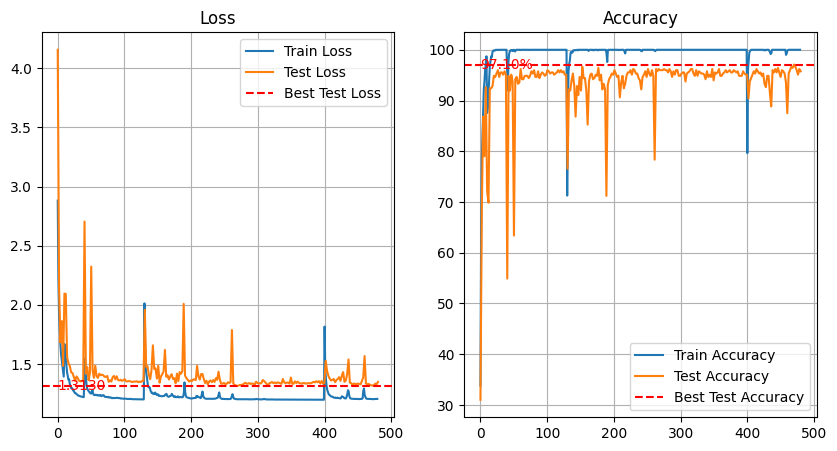

In [10]:
# plot the training and testing loss and accuracy
train_loss = [stat[0] for stat in train_stats]
train_acc = [stat[1] for stat in train_stats]
test_loss = [stat[0] for stat in test_stats]
test_acc = [stat[1] for stat in test_stats]
x_test = np.linspace(0, len(train_loss), len(test_loss))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(x_test, test_loss, label='Test Loss')
plt.axhline(y=np.min(test_loss), color='r', linestyle='--', label='Best Test Loss')
plt.text(0, np.min(test_loss), f"{np.min(test_loss):.4f}", color='r', va='center', ha='left')
plt.title('Loss')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(x_test, test_acc, label='Test Accuracy')
plt.axhline(y=np.max(test_acc), color='r', linestyle='--', label='Best Test Accuracy')
plt.text(0, np.max(test_acc), f"{np.max(test_acc):.2f}%", color='r', va='center', ha='left')
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()

100%|██████████| 14/14 [00:00<00:00, 49.66it/s]


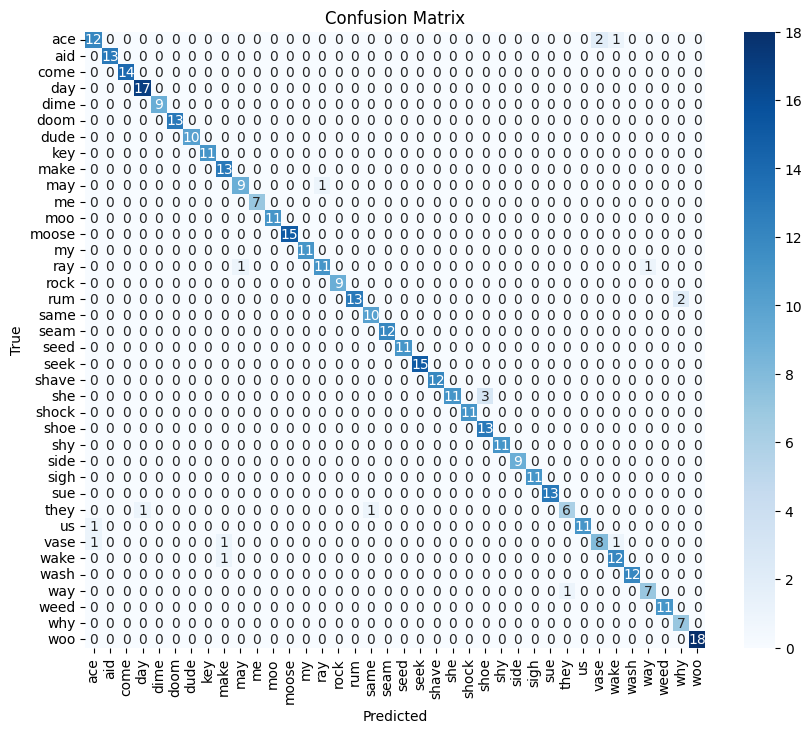

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to evaluate the model and generate the confusion matrix
def evaluate_model(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for ids, audio, adc1, adc2 in tqdm(dataloader):
            # adc1 = adc1.to(device)
            # adc2 = adc2.to(device)
            audio = audio.to(device)
            audio = audio.unsqueeze(1)
            ids = ids.to(device)
            
            # adc = torch.stack((adc1, adc2), dim=1)
            outputs = model(audio)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(ids.cpu().numpy())
    
    return all_labels, all_preds

# Evaluate the model on the validation set
labels, preds = evaluate_model(model, val_loader, device=global_device)

# Generate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Replace IDs with dataset names
label_names = [dataset.id_to_dataset(label) for label in range(output_length)]
pred_names = [dataset.id_to_dataset(pred) for pred in range(output_length)]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pred_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()